# Final Model

Indlæsning af biblioteker:

In [5]:
import pandas_datareader as webreader # Remote data access for pandas
import math # Mathematical functions 

import numpy as np 
import pandas as pd 

from datetime import date, timedelta, datetime #Date Functions

from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

# Measuring model performance / errors
import keras
from keras import backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler
import csv
from csv import reader

In [3]:
# Setting the timeframe for the data extraction
today = date.today()
date_today ='2021-04-20'
date_start = '2000-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Create a quick overview of the dataset
data = df.copy()

# Make sure data is sorted by date
data = data.sort_values(by=['Date'])

# Splitting month and year to seperate columns
d = pd.to_datetime(data.index) # The index column is our dates
data['Month'] = d.strftime('%m')
data['Year'] = d.strftime('%y')

# We will now reset the index and drop the dates
date_index = data.index
data = data.reset_index(drop = True)

features = ['High', 'Low', 'Open', 'Volume', 'Month', 'Close']

#reduce dataset for selected features
data_filtered = data[features] # Used for plotting later
data = data[features]

data['High_lag1'] = data['High'].shift(1)
data['Low_lag1'] = data['Low'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Close_lag1'] = data['Close'].shift(1)
data['Open_lag1'] = data['Open'].shift(1)

features = ['High_lag1', 'Low_lag1', 'Close_lag1', 'Open_lag1', 'Volume_lag1', 'Close']

#reduce dataset for selected features and just scale whole dataset as pct_change
data_filtered = data[features] # Used for plotting later
data = data[features]
data['Close'] = data['Close'].pct_change()
data['Close_lag1'] = data['Close_lag1'].pct_change()
data['High_lag1'] = data['High_lag1'].pct_change()
data['Low_lag1'] = data['Low_lag1'].pct_change()
data['Volume_lag1'] = data['Volume_lag1'].pct_change()
data['Open_lag1'] = data['Open_lag1'].pct_change()
data = data.iloc[1:]

n = len(data) # Number of rows in dataset

# Convert data to np arrays
X = np.array(data.drop(['Close'], axis = 1))
X = np.delete(X, (0), axis=0)
y = np.array(data['Close']).reshape(len(data), 1)

train_percent = 0.8 # Percentage of data used for training
sequence_length = 100 # Number of time steps remembered in model

X_train_temp, y_train_temp, X_val_temp, y_val_temp ,X_test_temp, y_test_temp = X[:round(len(X)*train_percent)], y[:round(len(X)*train_percent)], X[round(len(X)*train_percent):round(len(X)*(train_percent+(1-train_percent)*0.5))], y[round(len(X)*train_percent):round(len(X)*(train_percent+(1-train_percent)*0.5))], X[round(len(X)*(train_percent+(1-train_percent)*0.5)):], y[round(len(X)*(train_percent+(1-train_percent)*0.5)):]

# Reshaping the data so it fits a LSTM in Keras
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, 100 time steps per sample, and 2 features

X_train, y_train = [], []

# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, 100 time steps per sample, and 2 features
for i in range(sequence_length, round(len(X)*train_percent)):
    X_train.append(X_train_temp[i-sequence_length:i,:]) 
    y_train.append(y_train_temp[i, 0]) 

X_train, y_train = np.array(X_train), np.array(y_train).reshape(len(y_train), 1)

X_val, y_val = [], []

for i in range(sequence_length, len(X_val_temp)-1):
    X_val.append(X_test_temp[i-sequence_length:i,:]) 
    y_val.append(y_test_temp[i, 0]) 
X_val, y_val = np.array(X_val), np.array(y_val).reshape(len(y_val), 1)

X_test, y_test = [], []

for i in range(sequence_length, len(X_test_temp)):
    X_test.append(X_test_temp[i-sequence_length:i,:]) 
    y_test.append(y_test_temp[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test).reshape(len(y_test), 1)

val_range = list(range(round(len(X)*train_percent),round(len(X)*(train_percent+(1-train_percent)*0.5))))
test_range = list(range(round(len(X)*(train_percent+(1-train_percent)*0.5)),len(X)))

def loss_function0(y_true, y_pred):
    alpha = 20.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*(y_true - y_pred), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)

#### Creating model:

In [31]:
# Configure the neural network model
param = []

model = Sequential()

model.add(LSTM(100, return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]))) 

model.add(LSTM(100, return_sequences=False, 
               input_shape=(X_train.shape[1], X_train.shape[2]))) 

model.add(Dense(1, activation = 'linear'))

# Compile the model
model.compile(optimizer = 'adam', loss=loss_function0)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, batch_size = 32, validation_data=(X_val, y_val), 
                    epochs=40, callbacks=[early_stop])

predictions = model.predict(X_test)

Epoch 1/40
131/131 [==============================] - 14s 87ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 2/40
131/131 [==============================] - 13s 98ms/step - loss: 0.0110 - val_loss: 0.0120
Epoch 3/40
131/131 [==============================] - 14s 108ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 4/40
131/131 [==============================] - 14s 109ms/step - loss: 0.0106 - val_loss: 0.0114
Epoch 5/40
131/131 [==============================] - 17s 132ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 6/40
131/131 [==============================] - 15s 113ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 7/40
131/131 [==============================] - 14s 109ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 8/40
131/131 [==============================] - 14s 108ms/step - loss: 0.0097 - val_loss: 0.0104
Epoch 9/40
131/131 [==============================] - 14s 109ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 10/40
131/131 [==============================] - 14s 108ms/step - los

**Saving model:**

In [32]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights("model.h5")

**Loading the model**:

In [12]:
file = open('model.json', 'r')
loaded  = file.read()
file.close()

loaded_model = model_from_json(loaded)
loaded_model.load_weights("model.h5")

#### Evaluating models:

In [13]:
def showTrain(history):
    # Plot training & validation loss values
    fig, ax = plt.subplots(figsize=(9.2, 10.8), sharex=True)
    plt.plot(history.history["loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(len(history.history['loss'])))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()
    
def plot_future(prediction, y_test):
    plt.rcParams.update({'font.size': 12})
    #y_test = sc_y.inverse_transform(y_test)
    #prediction = sc_y.inverse_transform(prediction)
    plt.figure(figsize=(17.1, 10.8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Sande Afkast', color = '#a1d2ff')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Model Afkast', color = '#41719C')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.xlim([0, len(y_test)])
    plt.xlabel('Dage (antal)')
    plt.ylabel('Dagligt Afkast')
    

In [14]:
predictions = loaded_model.predict(X_test)

In [38]:
results = model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 22ms/step - loss: 0.0095


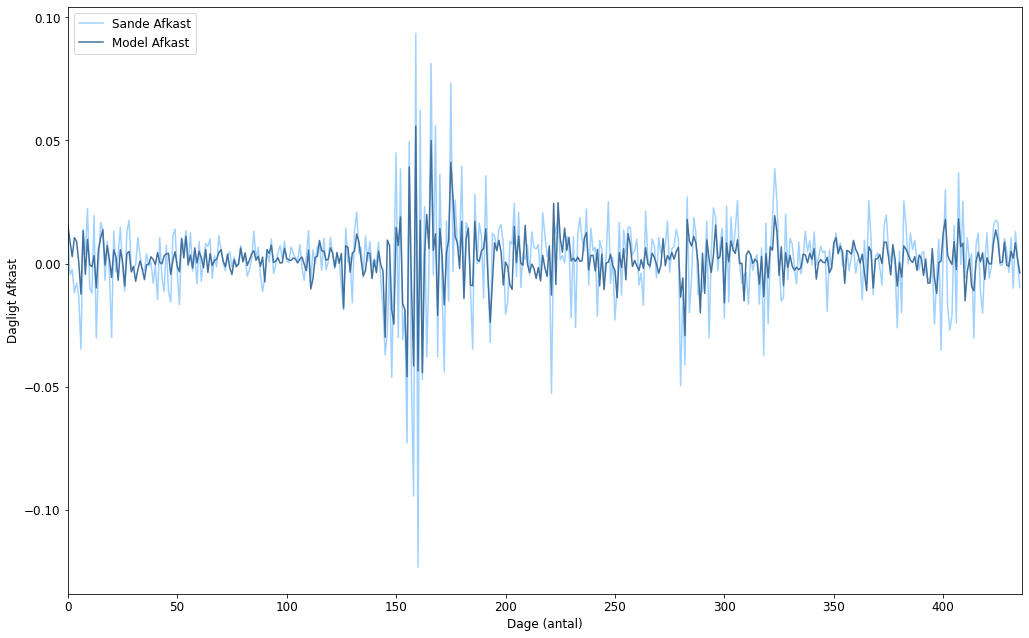

In [16]:
plot_future(predictions, y_test) 

**Algorithmic Trading test:**

In [16]:
pris = 8330.209961 #NASDAQ kurs til t = 0

kurs = []


#Kursen i testperioden kan nu bestemmes:
for i in range(len(y_test)):
    kurs.append(pris)
    pris = pris + pris * y_test[i]

In [17]:
M = 1 #Pengemængde til t = 0

x_buy = []
x_sell = []
buy = []
sell = []
M_udvikling  = []

for i in range(len(predictions)):
    M_udvikling.append(M)
    if predictions[i] > 0.01:
        M = M + M * y_test[i]      
        
for i in range(len(M_udvikling)):
    if M_udvikling[i] > M_udvikling[i-1] and M_udvikling[i-1] > M_udvikling[i-2]:
        continue
    elif M_udvikling[i] > M_udvikling[i-1]:
        buy.append(kurs[i][0])
        x_buy.append(i+1)
    elif M_udvikling[i] == M_udvikling[i-1] and M_udvikling[i-1] == M_udvikling[i-2]:
        continue
    elif M_udvikling[i] == M_udvikling[i-1]:
        sell.append(kurs[i][0])
        x_sell.append(i+1)        
M

array([2.93793012])

In [18]:
#Afkast i perioden på selve aktien
M = 1

for i in range(len(y_test)):
    M = M + M*y_test[i]
M

array([1.68898488])

In [81]:
def plot_return(M_udviklings, kurss, buy, sell):
    plt.rcParams.update({'font.size': 12})
    
    fig, ax1 = plt.subplots(figsize=(16, 9))

    color = '#41719C'
    ax1.set_xlabel('Dage (antal)')
    ax1.set_ylabel('kursudvikling', color=color)
    ax1.plot(kurss, color=color, label = 'NASDAQ kurs')
    ax1.set_xlim([0, len(y_test)])
    ax1.scatter(x_buy, buy, c='#00ff00', label='køb')
    ax1.scatter(x_sell, sell, c='#ff0000', label='sælg')
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    right_side = ax1.spines["top"]
    right_side.set_visible(False)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    right_side = ax2.spines["top"]
    right_side.set_visible(False)

    color = '#000000'
    ax2.set_ylabel('model afkast', color=color)  # we already handled the x-label with ax1
    ax2.plot(M_udviklings, color=color, label = 'algoritme afkast')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend(loc='upper center', prop={'size': 12})

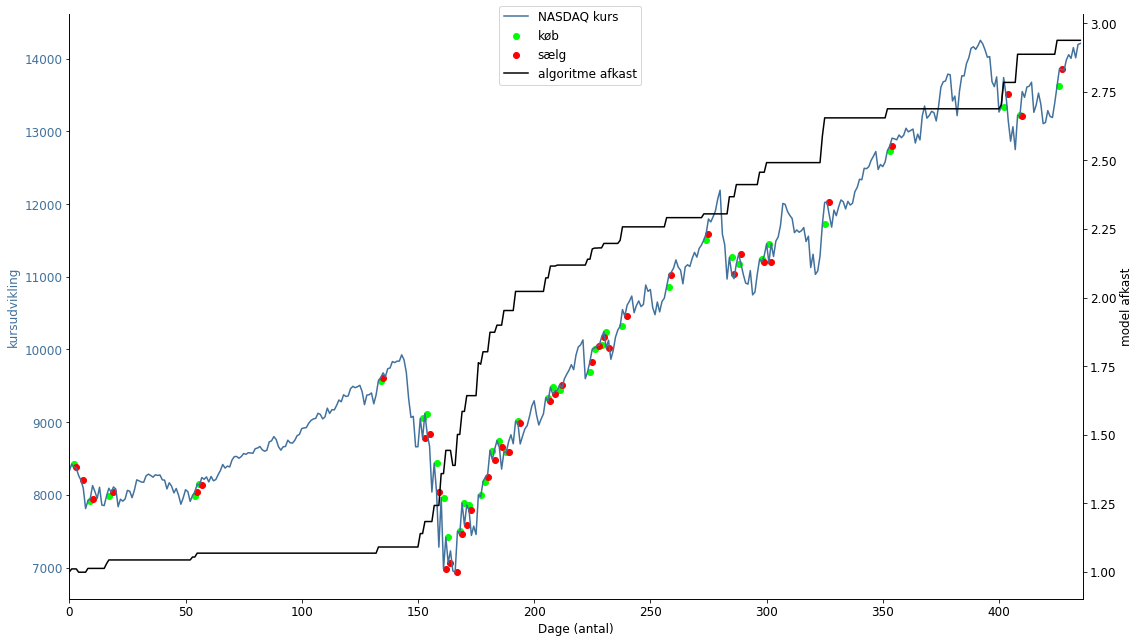

In [82]:
plot_return(M_udvikling, kurs, buy, sell)